In [1]:
!pip install fastjet
!pip install vector
!pip install uproot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.1/865.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.7/636.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.3/362.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00


In [2]:
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_ZH_H_ssbar_ecm_240GeV.root"
tree = uproot.open(data_file)["events"]

Mounted at /content/drive


In [4]:
tree.num_entries # number of events

100000

In [5]:
tree.keys()

['Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'ReconstructedParticles',
 'ReconstructedParticles/ReconstructedParticles.type',
 'ReconstructedParticles/ReconstructedParticles.energy',
 'ReconstructedParticles/ReconstructedParticles.momentum.x',
 'ReconstructedParticles/ReconstructedParticles.momentum.y',
 'ReconstructedParticles/ReconstructedParticles.momentum.z',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.x',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.y',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.z',
 'ReconstructedParticles/ReconstructedParticles.charge',
 'ReconstructedParticles/ReconstructedParticles.mass',
 'ReconstructedParticles/ReconstructedParticles.goodnessOfPID',
 'ReconstructedParticles/ReconstructedParticles.covMatrix[10]',
 'ReconstructedParticles/ReconstructedParticles.clusters_begin',
 'ReconstructedParticles/ReconstructedParticles.clusters_end',
 'ReconstructedParticles/ReconstructedParti

In [6]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Muon#0               | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Mu...
Muon#0/Muon#0.index  | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon#0/Muon#0.col... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | vector<edm4hep::Recon... | AsGroup(<TBranchElement 'Re...
ReconstructedPart... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
R

In [7]:
pid = tree['Particle.PDG'].array()
p_status = tree['Particle.generatorStatus'].array()
m = tree['Particle.mass'].array()
px = tree['Particle.momentum.x'].array()
py = tree['Particle.momentum.y'].array()
pz = tree['Particle.momentum.z'].array()
p_begin = tree['Particle.parents_begin'].array()
p_end = tree['Particle.parents_end'].array()
p_ind = tree['Particle#0.index'].array()

In [8]:
def energy(m, px, py, pz):
    E = np.sqrt( m**2 + px**2 + py**2 + pz**2)
    return E

In [9]:
e = energy(m, px, py, pz)

In [10]:
def get_parent_ids(i, particle_ids, parent_indices, parents_begin, parents_end) :

  pb = parents_begin[i]
  pe = parents_end[i]

  if pb == pe :
    return 0, 0
  else :
    for id in range(pb, pe) :
      parent_indx = parent_indices[id]
      parent_id = particle_ids[parent_indx]
    return parent_id, parent_indx

In [11]:
def find_parent_and_daughter_ids(indices, particle_ids, all_particle_ids):
    """
    Find parent IDs and corresponding daughter IDs for each repeated index.

    Parameters:
        indices (list): A list of parent indices corresponding to stable particles.
        particle_ids (list): A list of IDs corresponding to stable particles.
        all_particle_ids (list): A list of all particle IDs.

    Returns:
        list: [[parent ID, list of daughter IDs),...,....].
    """
    if len(indices) != len(particle_ids):
        raise ValueError("Indices and particle_ids must have the same length.")
    if len(indices) > len(all_particle_ids):
        raise ValueError("Indices cannot reference more particles than all_particle_ids.")

    # Count occurrences of each index
    counts = Counter(indices)

    # Identify repeated indices
    repeated_indices = {index for index, count in counts.items() if count >= 2}

    # Collect parent and daughter IDs for repeated indices
    parent_daughters = []
    for index in repeated_indices:
        parent_id = all_particle_ids[index]  # Get the parent ID using the index
        daughters = [particle_ids[i] for i in range(len(indices)) if indices[i] == index]
        parent_daughters.append([index, parent_id, daughters])

    return parent_daughters

In [12]:
def f(R) : # R is the radius parameter
  n_jets = [] # a list containing number of jets in each event
  dijet_m = []
  dijet_pt = [] # a list containing jets pT
  dijet_eta = [] # a list containing jets eta
  dijet_constituents = []

  photon_count = []
  muon_count = []
  electron_count = []
  Ks_count = []
  lambda_count = []
  lambdabar_count = []

  photon_e = []
  muon_e = []
  electron_e = []
  Ks_e = []
  lambda_e = []
  lambdabar_e = []

  N = 10000 # number of events

  for n in range(N) : # taking upto N events
    particles_list = [] # a list of particles in an event

    Leading_indx_0 = [] # a list of indices of leading jets
    Leading_indx_1 = []

    parent_indices_0 = []
    parent_indices_1 = []

    photon_counts_0 = 0
    muon_counts_0 = 0
    electron_counts_0 = 0
    Ks_counts_0 = 0
    lambda_counts_0 = 0
    lambdabar_counts_0 = 0

    photon_e_0 = 0
    muon_e_0 = 0
    electron_e_0 = 0
    Ks_e_0 = 0
    lambda_e_0 = 0
    lambdabar_e_0 = 0

    photon_counts_1 = 0
    muon_counts_1 = 0
    electron_counts_1 = 0
    Ks_counts_1 = 0
    lambda_counts_1 = 0
    lambdabar_counts_1 = 0

    photon_e_1 = 0
    muon_e_1 = 0
    electron_e_1 = 0
    Ks_e_1 = 0
    lambda_e_1 = 0
    lambdabar_e_1 = 0


    sts = p_status[n]
    p_x = px[n]
    p_y = py[n]
    p_z = pz[n]
    E = e[n]
    ids = pid[n]
    pinds = p_ind[n]
    pbegin = p_begin[n]
    pend = p_end[n]

    for i in range(len(p_x)) : # looping over the particles in an event
      part_p4 = PseudoJet(float(p_x[i]), float(p_y[i]), float(p_z[i]), float(E[i]))
      part_p4.set_user_index(i) # setting the index of the particle
      particles_list.append(part_p4)

    stable_p4 = []

    for i in range(len(particles_list)) :
      if sts[i] == 1 :
        stable_p4.append(particles_list[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster = ClusterSequence(stable_p4, JetDefinition(antikt_algorithm, R))
    jet_set = sorted_by_pt(cluster.inclusive_jets()) # jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT)

    # Dijet kinematics
    dijet = jet_set[0] + jet_set[1]
    d_m = dijet.m() # invariant mass
    d_pt = dijet.pt() # transverse momentum
    d_eta = dijet.eta() # pseudo rapidity
    d_e = dijet.e() # energy

    Leading_constituents_0 = jet_set[0].constituents()

    for i in range(len(Leading_constituents_0)) :
      Leading_indx_0.append(Leading_constituents_0[i].user_index())

    for j in Leading_indx_0 :
      if ids[j] == 22 :
        photon_counts_0 += 1
        photon_e_0 += particles_list[j].e()
      if ids[j] == 13 :
        muon_counts_0 += 1
        muon_e_0 += particles_list[j].e()
      if ids[j] == 11 :
        electron_counts_0 += 1
        electron_e_0 += particles_list[j].e()

      parent_id_0, parent_indx_0 = get_parent_ids(j, ids, pinds, pbegin, pend)
      parent_indices_0.append(parent_indx_0)

    Leading_ids_0 = ids[Leading_indx_0]
    pd_0 = find_parent_and_daughter_ids(parent_indices_0, Leading_ids_0, ids)

    for k in range(len(pd_0)) :
      indx_0 = pd_0[k][0]
      id_0 = pd_0[k][1]
      if id_0 == 310 :
        Ks_counts_0 += 1
        Ks_e_0 += particles_list[indx_0].e()
      if id_0 == 3122 :
        lambda_counts_0 += 1
        lambda_e_0 += particles_list[indx_0].e()
      if id_0 == -3122 :
        lambdabar_counts_0 += 1
        lambdabar_e_0 += particles_list[indx_0].e()

    Leading_constituents_1 = jet_set[1].constituents()

    for i in range(len(Leading_constituents_1)) :
      Leading_indx_1.append(Leading_constituents_1[i].user_index())

    for j in Leading_indx_1 :
      if ids[j] == 22 :
        photon_counts_1 += 1
        photon_e_1 += particles_list[j].e()
      if ids[j] == 13 :
        muon_counts_1 += 1
        muon_e_1 += particles_list[j].e()
      if ids[j] == 11 :
        electron_counts_1 += 1
        electron_e_1 += particles_list[j].e()

      parent_id_1, parent_indx_1 = get_parent_ids(j, ids, pinds, pbegin, pend)
      parent_indices_1.append(parent_indx_1)

    Leading_ids_1 = ids[Leading_indx_1]
    pd_1 = find_parent_and_daughter_ids(parent_indices_1, Leading_ids_1, ids)

    for k in range(len(pd_1)) :
      indx_1 = pd_1[k][0]
      id_1 = pd_1[k][1]
      if id_1 == 310 :
        Ks_counts_1 += 1
        Ks_e_1 += particles_list[indx_1].e()
      if id_1 == 3122 :
        lambda_counts_1 += 1
        lambda_e_1 += particles_list[indx_1].e()
      if id_1 == -3122 :
        lambdabar_counts_1 += 1
        lambdabar_e_1 += particles_list[indx_1].e()

    photon_energy = photon_e_0 + photon_e_1
    muon_energy = muon_e_0 + muon_e_1
    electron_energy = electron_e_0 + electron_e_1
    Ks_energy = Ks_e_0 + Ks_e_1
    lambda_energy = lambda_e_0 + lambda_e_1
    lambdabar_energy = lambdabar_e_0 + lambdabar_e_1

    N_constituents = len(Leading_constituents_0) + len(Leading_constituents_1)

    photon_counts = photon_counts_0 + photon_counts_1
    muon_counts = muon_counts_0 + muon_counts_1
    electron_counts = electron_counts_0 + electron_counts_1
    Ks_counts = Ks_counts_0 + Ks_counts_1
    lambda_counts = lambda_counts_0 + lambda_counts_1
    lambdabar_counts = lambdabar_counts_0 + lambdabar_counts_1

    n_jets.append(len(jet_set))
    dijet_m.append(d_m)
    dijet_pt.append(d_pt)
    dijet_eta.append(d_eta)
    dijet_constituents.append(N_constituents)

    photon_e.append(photon_energy)
    muon_e.append(muon_energy)
    electron_e.append(electron_energy)
    Ks_e.append(Ks_energy)
    lambda_e.append(lambda_energy)
    lambdabar_e.append(lambdabar_energy)

    photon_count.append(photon_counts)
    muon_count.append(muon_counts)
    electron_count.append(electron_counts)
    Ks_count.append(Ks_counts)
    lambda_count.append(lambda_counts)
    lambdabar_count.append(lambdabar_counts)

  return n_jets, dijet_m, dijet_pt, dijet_eta, dijet_constituents, photon_count, muon_count, electron_count, Ks_count, lambda_count, lambdabar_count, photon_e, muon_e, electron_e, Ks_e, lambda_e, lambdabar_e

In [13]:
R = f(0.8)

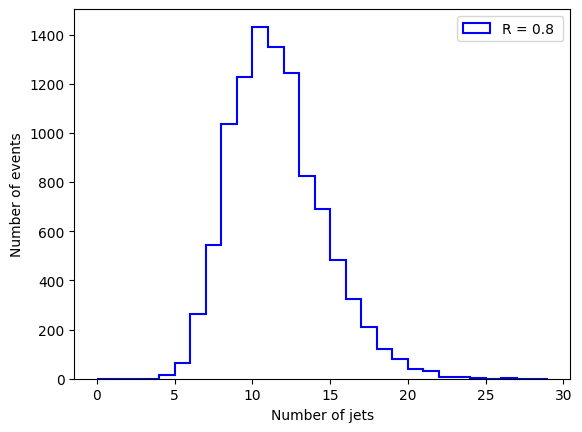

In [14]:
n_jets = R[0]
plt.hist(n_jets, bins = np.arange(0, 30), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

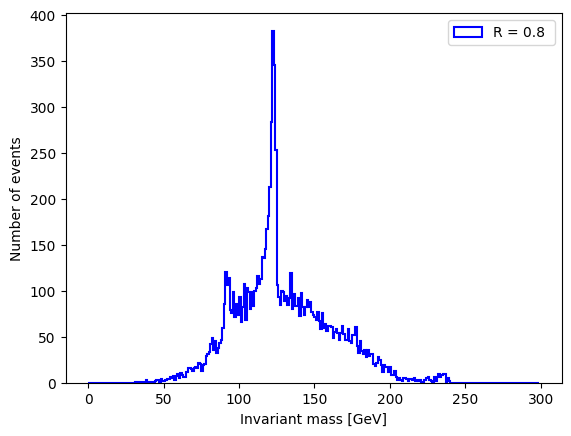

In [15]:
dijet_m = R[1]
plt.hist(dijet_m, bins = np.arange(0, 300), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Invariant mass [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

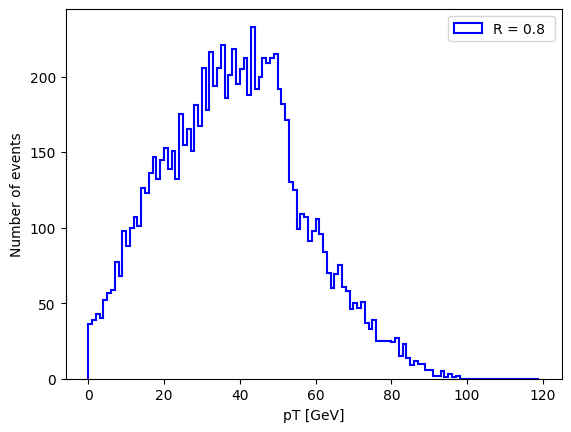

In [16]:
dijet_pt = R[2]
plt.hist(dijet_pt, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("pT [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

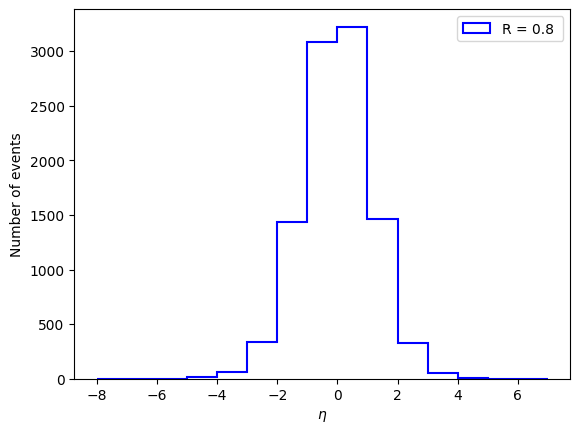

In [17]:
dijet_eta = R[3]
plt.hist(dijet_eta, bins = np.arange(-8, 8), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$\eta$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

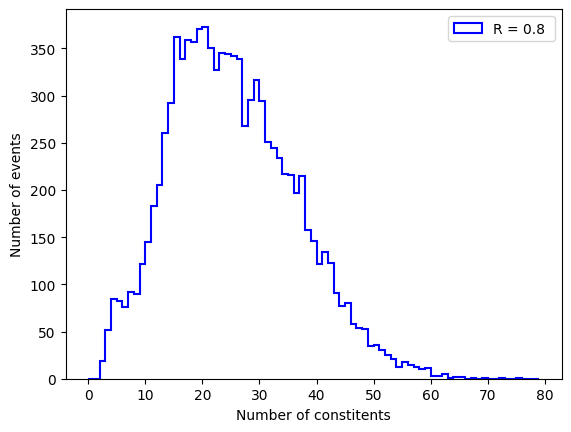

In [18]:
dijet_constituents = R[4]
plt.hist(dijet_constituents, bins = np.arange(0, 80), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of constitents")
plt.ylabel("Number of events")
plt.legend()
plt.show()

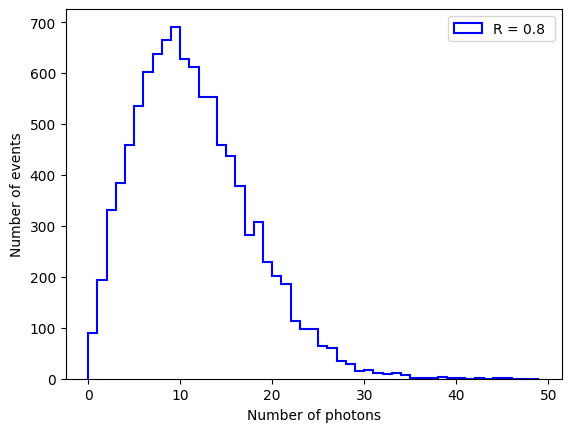

In [19]:
n_photons = R[5]
plt.hist(n_photons, bins = np.arange(0, 50), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of photons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

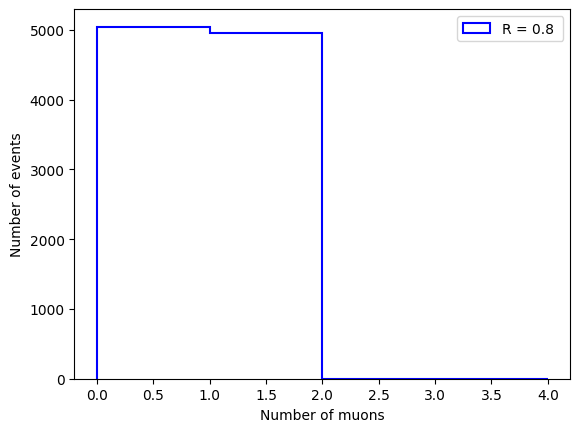

In [20]:
n_muons = R[6]
plt.hist(n_muons, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of muons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

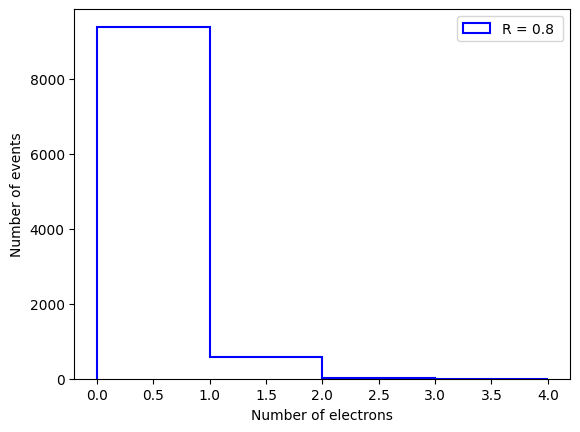

In [21]:
n_electrons = R[7]
plt.hist(n_electrons, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of electrons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

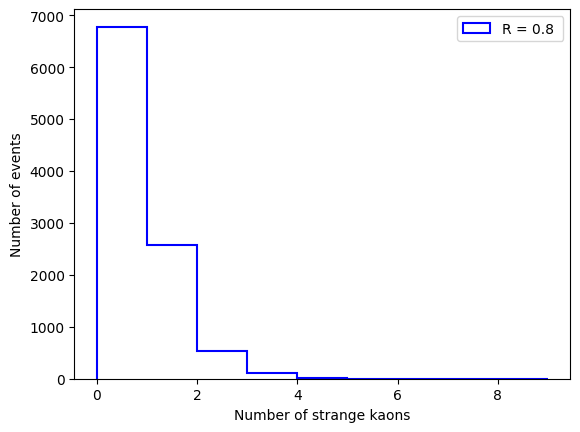

In [22]:
n_ks = R[8]
plt.hist(n_ks, bins = np.arange(0, 10), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of strange kaons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

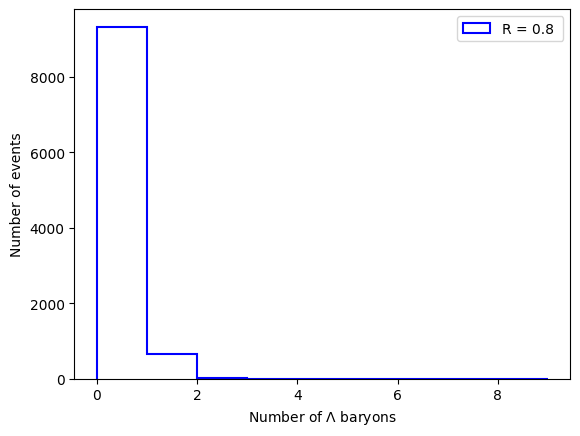

In [23]:
n_lb = R[9]
plt.hist(n_lb, bins = np.arange(0, 10), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of $\Lambda$ baryons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

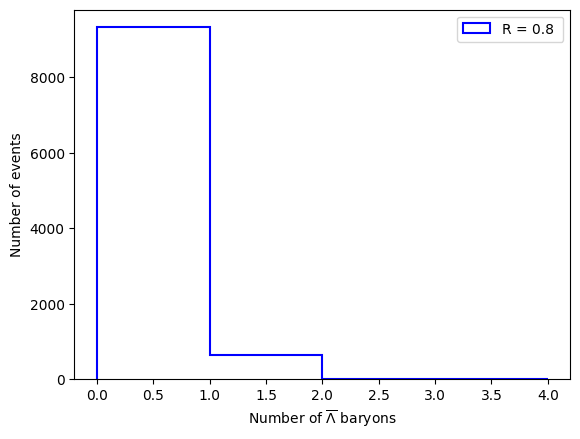

In [24]:
n_alb = R[10]
plt.hist(n_alb, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel(r"Number of $\overline {\Lambda}$ baryons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

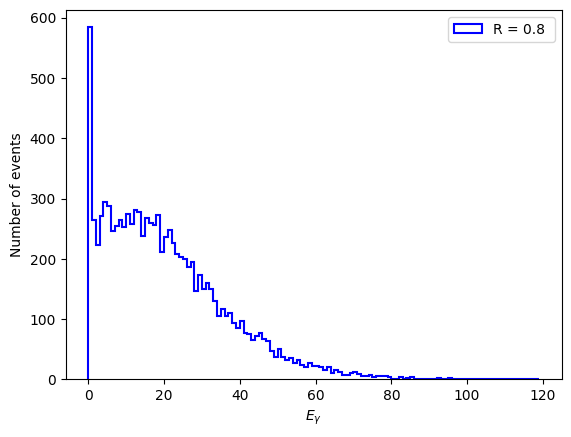

In [32]:
photon_e = R[11]
plt.hist(photon_e, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\gamma}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

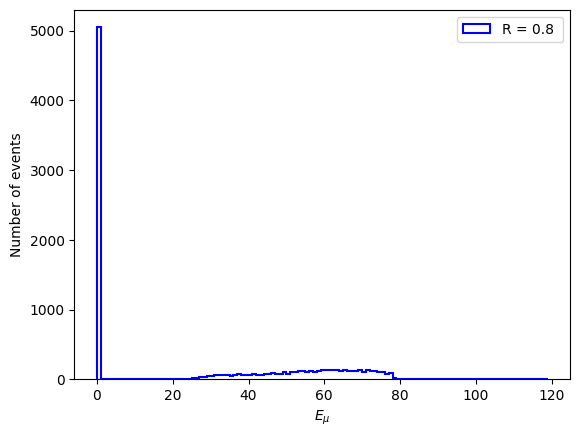

In [33]:
muon_e = R[12]
plt.hist(muon_e, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\mu}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

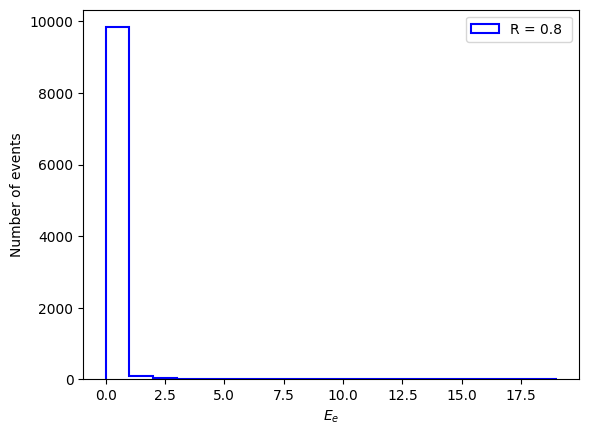

In [35]:
electron_e = R[13]
plt.hist(electron_e, bins = np.arange(0, 20), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{e}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

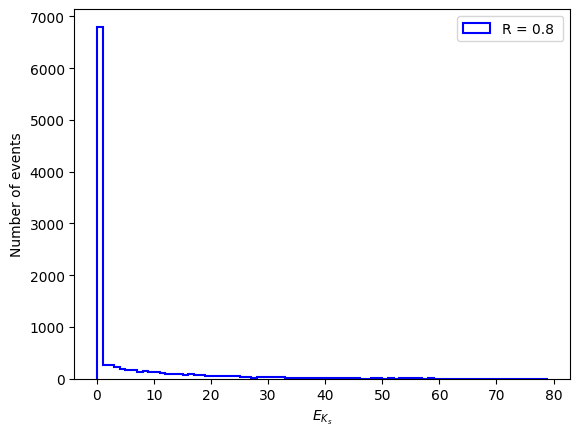

In [37]:
Ks_e = R[14]
plt.hist(Ks_e, bins = np.arange(0, 80), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{K_{s}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

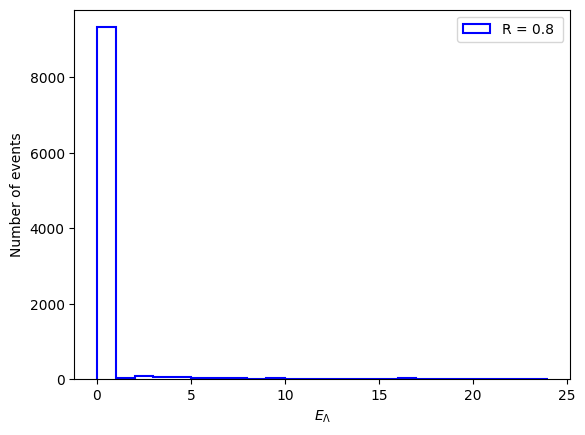

In [41]:
lambda_e = R[15]
plt.hist(lambda_e, bins = np.arange(0, 25), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\Lambda}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

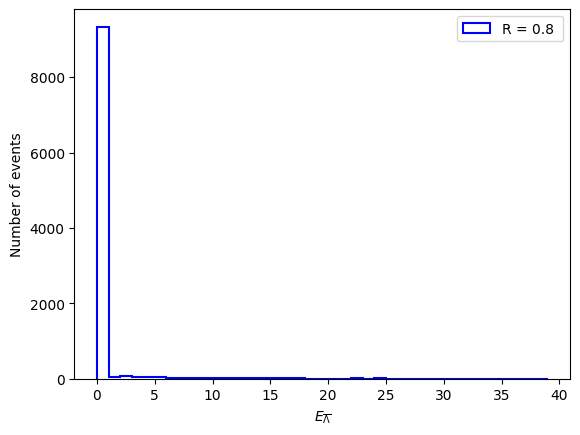

In [49]:
lambdabar_e = R[16]
plt.hist(lambdabar_e, bins = np.arange(0, 40), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel(r"$E_{\overline{\Lambda}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()